In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os
import pynwb
import graph
from tqdm import tqdm
from pathlib import Path 
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LassoCV
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

import matplotlib
import matplotlib.pyplot as plt
# from matplotlib_venn import venn2
import seaborn as sns

import load_data
import LFP
import single_neuron_vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sz1 = 16
sz2 = 18
sz3 = 12
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz3) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [3]:
tuning = pd.read_pickle("D:/SingleNeuron/Tuning all steps.pkl")

In [28]:
ses_info = {'session':['031723','032823','033123','032023','040423','040723','050824',  # Bart
               '101124', '100324', '092124', '092324', '092524', '100124','100924'],
           'animal': ['Bart']*7+['London']*7}
all_sessions = pd.DataFrame(ses_info)  # London
region = 'HPC'

for ii in [0]: #range(len(all_sessions)):

    date = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(animal, date)
    
    session_tuning = tuning.query('(Session==@date)&(region==@region)').copy()
    if np.all(np.isnan(session_tuning['unitNumber'].values)):
        session_tuning['unitNumber']=session_tuning['cluster_id']
    spike_table = load_data.load_beh_neural(animal, date, region, 'action_on', 'trialerror==0')
    
    spatial_ftest_pval =  np.stack(session_tuning['spatial_ftest_pval'].values)
    max_node_all = np.stack(session_tuning['max_node_all'].values)
    sig_diff_node_all = np.stack(session_tuning['sig_diff_node_all'].values)
    
    idx_min = np.argmin(spatial_ftest_pval,axis=1)
    rows = np.arange(spatial_ftest_pval.shape[0])
    
    spatial_pval = spatial_ftest_pval[rows, idx_min]
    max_node = max_node_all[rows, idx_min]
    sig_node = sig_diff_node_all[rows, idx_min]

    tele_idx = (spatial_pval<0.001) & (max_node==0) & (sig_node==15)
    tele0 = session_tuning.iloc[tele_idx]
    
    tele_idx = (spatial_pval<0.001) & (max_node==15) & (sig_node==15)
    tele15 = session_tuning.iloc[tele_idx]
    
    # for neuronID in teleporter.unitNumber.values.astype(int):
    #     plt.close('all')
    #     ax = single_neuron_vis.plot_sdf(spike_table, neuronID,'node', sns.color_palette('Set1',16), ax=None)
    #     ax.set_title(f'Unit {neuronID}')
    #     plt.savefig(f'D:/SingleNeuron/Session {date}, Unit {neuronID}, Teleporter')

Bart 031723
Building Spike Table


1499it [00:00, 4338.10it/s]


In [35]:
spikes, beh, unitNames = spike_table['spikes'],spike_table['beh'],spike_table['unitNames']

In [44]:
beh['nextnode'] = (
    beh
    .groupby('trial')['node']
    .shift(-1)
)
beh['prenode'] = (
    beh
    .groupby('trial')['node']
    .shift(1)
)
beh['step_save']=beh['spatial_distance']-beh['graph_distance']

In [52]:
def plot_sem(time, trace, ax, ii):

    colors = sns.color_palette('Set1',3)
    mean_trace = trace.mean(axis=0)
    sem_trace = trace.std(axis=0)/np.sqrt(trace.shape[0])
    ax.plot(time, mean_trace, color=colors[ii])
    ax.fill_between(time,
                    mean_trace - sem_trace,
                    mean_trace + sem_trace,
                    color=colors[ii],
                    alpha=0.3)

In [ ]:
for tt in range(len(df)):
    raster = np.where(df.iloc[tt]['spikes'])[0]
    idx = np.where(unique_vals == df.iloc[tt][var])[0][0]
    ax.vlines(raster, tt, tt + 0.8, color=colors[idx], lw=0.5)

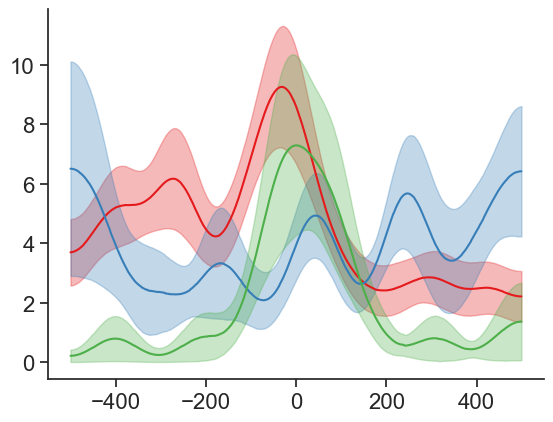

In [55]:
sdf = []
neuronID = 193
plt.close('all')
fig, ax = plt.subplots()
time = np.arange(-500,500)

for ii, prenode in enumerate([0,11,14]):
    idx = (beh.node==15) & (beh.prenode==prenode)
    temp = single_neuron_vis.get_sdf(spikes[idx,:,unitNames.unitNumber==neuronID])
    plot_sem(time, temp, ax, ii)
    sdf.append(temp)

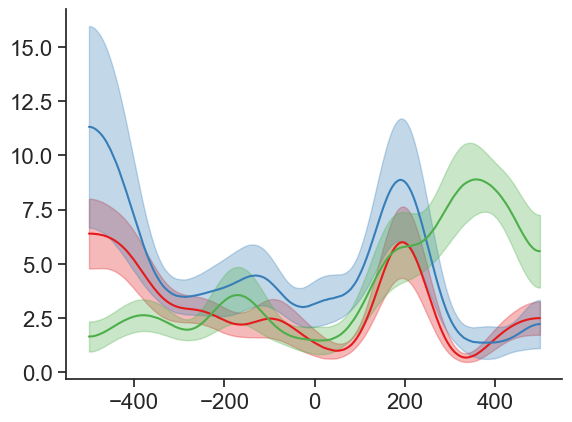

In [56]:
sdf = []
neuronID = 193
plt.close('all')
fig, ax = plt.subplots()
time = np.arange(-500,500)

for ii, nextnode in enumerate([1,4,15]):
    idx = (beh.node==0) & (beh.nextnode==nextnode)
    temp = single_neuron_vis.get_sdf(spikes[idx,:,unitNames.unitNumber==neuronID])
    plot_sem(time, temp, ax, ii)
    sdf.append(temp)